In [2]:
import pandas as pd
import numpy as np
import numpy.matlib as nm

from tqdm import tqdm
import time

import warnings
warnings.filterwarnings("ignore")

import scipy.io as sio
from scipy.constants import R
import scipy

import matplotlib.pyplot as plt
import matplotlib.colors as colors
import matplotlib as mpl

import sklearn
from sklearn.metrics.pairwise import pairwise_distances
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, QuantileTransformer, Normalizer, RobustScaler
from sklearn.model_selection import ShuffleSplit

from sklearn.cluster import KMeans
from sklearn.metrics import mean_squared_error, r2_score

from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusioNatrix, plot_confusioNatrix
from sklearn.metrics import roc_auc_score 
from sklearn.metrics import plot_roc_curve

from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.svm import SVC

from sklearn import model_selection

from mp_api.client import MPRester

# 1. Introduction
* The dataset containes 17220 different adsorption sites generated from 626 different intermetallic materials. Each site is feauturized by the information of coordination atoms of the adsorbate and 8 neighbor atoms of the coordination. Each atoms are described by their group number, periodic number, electronegativity and the number of unpaired d electrons.
* 10000 data points are selected randomly from the whole dataset.
* The LOCO cross-validation folds were defined according the result of K-Means Clustering. Split methond from previous assignment(split on mp-id/structure) is not performed, since there would be too many folds,  the size of validation set might be too small as a valuable reference for hyperparameter tuning.
* the full set of features are used for classification
* the variable modeled is the target property: hydrogen adsorption energy 
* The goal of thise report is to develop a classifier that can either efficienly defect the adsorption site with a near-optimal adsorption energy (-0.37 eV to -0.17 eV), or at least to screening sites that are not likely to have a optimal adsorption energy.

# 2. Coding Section

### 2.0 Importing Dataset

In [106]:
df = pd.read_csv('h_data_modelinput.csv').drop(columns=['Unnamed: 0'])
df.index = range(len(df))
print('# of adsorption sites:', len(df))
print('# of features:', df.shape[1]-3)
print("type of intermetallic materials:",len(df['mpid'].unique()))

# of adsorption sites: 10000
# of features: 53
type of intermetallic materials: 626


In [108]:
# create a dictionary for mp-id and the corresponding list of elements of the material 
mp_list = list(df['mpid'].unique())
prop = ['material_id','chemsys']
formu_elem = {}
with MPRester("JcjACBt45HOv4RNHua4YOSrdWEFqoIJw") as mpr:
    docs = mpr.summary.search(material_ids=mp_list,fields=prop)
    formu_elem['mp_id']=[str(getattr(doc, 'material_id')) for doc in docs]
    formu_elem['chemsys']= [getattr(doc,'chemsys').split('-') for doc in docs]
formu_elem = pd.DataFrame.from_dict(formu_elem) 
dic = dict(zip(formu_elem.mp_id, formu_elem.chemsys))

# create a new column of chemical symbols
df['chemsys']=df['mpid'].map(dic)

# reorder the column for later operation
col_old = list(df.keys())
# print(len(col_old))
col_new = ['mpid', 'formula', 'chemsys','energy', 'shift','miller', 'top', '0group', '0period', '0en', '0upd', '1group', '1period', '1en', '1upd', '2group', '2period', '2en', '2upd', '3group', '3period', '3en', '3upd', '4group', '4period', '4en', '4upd', '5group', '5period', '5en', '5upd', '6group', '6period', '6en', '6upd', '7group', '7period', '7en', '7upd', '8group', '8period', '8en', '8upd', '9group', '9period', '9en', '9upd', '10group', '10period', '10en', '10upd', '11group', '11period', '11en', '11upd']
# print(set(col_old)==set(col_new))
df=df[col_new]

df.head(10)

Retrieving SummaryDoc documents: 100%|██████████| 626/626 [00:00<?, ?it/s]


,mpid,formula,chemsys,energy,shift,miller,top,0group,0period,0en,...,9en,9upd,10group,10period,10en,10upd,11group,11period,11en,11upd
0,mp-1281,VIr,"[Ir, V]",-0.306901,0.000000,12,0,9,6,2.20,...,1.630000,3.000000,9.000000,6.000000,2.200000,3.000000,5.000000,4.000000,1.630000,3.000000
1,mp-630976,In3Ir,"[In, Ir]",-0.151933,0.051690,2,1,13,5,1.78,...,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000
2,mp-22079,AsRh,"[As, Rh]",-0.307631,0.047132,6,1,9,5,2.28,...,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966
3,mp-979980,VPd3,"[Pd, V]",0.030970,0.001398,2,0,10,5,2.20,...,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000
4,mp-1841,SiIr3,"[Ir, Si]",0.571183,0.078788,15,1,9,6,2.20,...,2.200000,3.000000,9.000000,6.000000,2.200000,3.000000,9.000000,6.000000,2.200000,3.000000
5,mp-866037,GaNiRh2,"[Ga, Ni, Rh]",-0.049823,0.120000,2,1,13,4,1.81,...,1.910000,2.000000,10.000000,4.000000,1.910000,2.000000,9.000000,5.000000,2.280000,2.000000
6,mp-672326,In3Ru,"[In, Ru]",-0.307108,0.077090,1,1,13,5,1.78,...,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000
7,mp-873,VPd3,"[Pd, V]",-0.165235,0.375000,12,1,10,5,2.20,...,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000
8,mp-1851,SnPd2,"[Pd, Sn]",-0.066199,0.135674,15,0,10,5,2.20,...,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000
9,mp-697068,SiPd2,"[Pd, Si]",0.006535,0.065647,2,0,10,5,2.20,...,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000


In [125]:
df.insert(0,'label', 0)

In [126]:
df['label'][(df['energy']< -0.17)&(df['energy']>-0.37)] = 1
print("Adsorption site with near ideal adsorption energy",len(df[df['label']==1]))
print("Adsorption site with non-ideal adsorption energy",len(df[df['label']==0]))

Adsorption site with near ideal adsorption energy 2175
Adsorption site with non-ideal adsorption energy 7825


In [7]:
corr = df.iloc[:,4:].corr().abs()
corr = corr.mask(np.tril(np.ones(corr.shape)).astype(bool)) # remove the lower triangle of values in the matrox 
corr.style.background_gradient(cmap='viridis')

,energy,shift,miller,top,0group,0period,0en,0upd,1group,1period,1en,1upd,2group,2period,2en,2upd,3group,3period,3en,3upd,4group,4period,4en,4upd,5group,5period,5en,5upd,6group,6period,6en,6upd,7group,7period,7en,7upd,8group,8period,8en,8upd,9group,9period,9en,9upd,10group,10period,10en,10upd,11group,11period,11en,11upd
energy,nan,0.067912,0.005452,0.014315,0.465045,0.053203,0.013170,0.370010,0.455312,0.046219,0.022184,0.369621,0.259394,0.013980,0.058407,0.208502,0.105680,0.010605,0.017927,0.090718,0.130507,0.002601,0.024832,0.132979,0.115137,0.013353,0.031280,0.124239,0.148612,0.018236,0.035557,0.147802,0.174253,0.036825,0.064385,0.152853,0.109853,0.027437,0.042509,0.118446,0.112630,0.024263,0.038605,0.116905,0.124879,0.000327,0.003142,0.121657,0.156108,0.016440,0.022638,0.160313
shift,nan,nan,0.039772,0.018134,0.023210,0.009896,0.027164,0.045550,0.005398,0.008246,0.026488,0.000371,0.018134,0.027847,0.003080,0.011511,0.000330,0.001765,0.005437,0.015357,0.054053,0.017481,0.033867,0.076770,0.041839,0.008624,0.044762,0.051690,0.032847,0.004150,0.039451,0.039197,0.052099,0.023262,0.052311,0.014552,0.053915,0.021378,0.041224,0.047604,0.056244,0.019970,0.045866,0.032913,0.057332,0.010619,0.047971,0.040669,0.048021,0.022071,0.052545,0.021821
miller,nan,nan,nan,0.023200,0.074000,0.030452,0.026182,0.078884,0.030391,0.030400,0.002021,0.062958,0.009371,0.002497,0.006448,0.012979,0.025116,0.017645,0.016300,0.019969,0.052713,0.009586,0.020964,0.065872,0.059585,0.015425,0.019778,0.071336,0.066897,0.024795,0.015725,0.076168,0.064687,0.026641,0.006355,0.077204,0.065545,0.011427,0.024144,0.077313,0.062213,0.016305,0.019378,0.065740,0.052818,0.013521,0.006635,0.070928,0.029817,0.031726,0.014558,0.051383
top,nan,nan,nan,nan,0.012115,0.015128,0.023143,0.006159,0.013560,0.017715,0.013361,0.009548,0.015929,0.001294,0.007645,0.018671,0.008093,0.001874,0.010286,0.001961,0.046438,0.051061,0.057190,0.004337,0.034553,0.042209,0.050212,0.003282,0.001644,0.007996,0.013804,0.008207,0.017521,0.002928,0.024095,0.009774,0.012274,0.032547,0.056446,0.004652,0.003334,0.033756,0.052713,0.009965,0.003204,0.016646,0.031184,0.003824,0.002353,0.001116,0.020906,0.004856
0group,nan,nan,nan,nan,nan,0.359816,0.135725,0.570973,0.363192,0.067379,0.003110,0.221630,0.143682,0.049252,0.069782,0.104554,0.087227,0.022863,0.032164,0.072224,0.278957,0.214192,0.140056,0.152683,0.206619,0.186686,0.132892,0.116504,0.180405,0.143522,0.101842,0.111479,0.177897,0.080716,0.029978,0.101328,0.189882,0.170230,0.134824,0.123239,0.179301,0.140219,0.127377,0.135344,0.209904,0.145734,0.138918,0.140006,0.211812,0.088701,0.065656,0.146218
0period,nan,nan,nan,nan,nan,nan,0.837889,0.186604,0.099968,0.466285,0.358412,0.023055,0.028506,0.091484,0.031959,0.029492,0.016859,0.046137,0.017128,0.003849,0.128317,0.536654,0.426795,0.053605,0.083472,0.494221,0.380848,0.004573,0.082304,0.453051,0.335002,0.019331,0.063209,0.415879,0.309445,0.028281,0.106505,0.502768,0.393180,0.017166,0.114130,0.473241,0.367265,0.017209,0.140358,0.473375,0.377388,0.024571,0.125582,0.418605,0.328371,0.020725
0en,nan,nan,nan,nan,nan,nan,nan,0.097549,0.013909,0.411071,0.440332,0.060892,0.010594,0.075938,0.056304,0.058084,0.005721,0.039229,0.032828,0.000341,0.071066,0.456877,0.497833,0.008777,0.052262,0.418987,0.443177,0.018240,0.062683,0.382877,0.392366,0.020333,0.033064,0.354193,0.365013,0.030166,0.081782,0.437020,0.437588,0.010202,0.091901,0.422074,0.407112,0.016174,0.102229,0.420501,0.423963,0.003457,0.069849,0.370021,0.380701,0.006357
0upd,nan,nan,nan,nan,nan,nan,nan,nan,0.229888,0.014478,0.057511,0.454501,0.072983,0.033694,0.080438,0.140783,0.051885,0.031827,0.023988,0.095371,0.126315,0.065036,0.056072,0.414986,0.056410,0.038719,0.043430,0.327097,0.029026,0.012094,0.022561,0.270144,0.035939,0.037924,0.024646,0.296229,0.096435,0.033075,0.028019,0.369305,0.116609,0.026170,0.014243,0.342905,0.129513,0.024087,0.033750,0.380305,0.113985,0.012624,0.001201,0.342550
1group,nan,nan,nan,nan,nan,nan,nan,nan,nan,0.173375,0.117921,0.5987

### 2.1 Clustering & Visualization

In [8]:
fea = df[list(df.keys())[5:]].to_numpy()     # exclude the first 4 columns "mpid", "formula", "chemsys","energy" that are not numerical features
scaler = StandardScaler()      # standardize the data
fea = scaler.fit_transform(fea)
n_components = fea.shape[-1] 
print("number of components:", n_components)

pca = PCA(n_components)                      # calculate the PCs and the explained variance 
pca.fit(fea)                                                 
loading_vectors = pca.components_
explained_variance = pca.explained_variance_
pos = pca.transform(fea)

number of components: 51


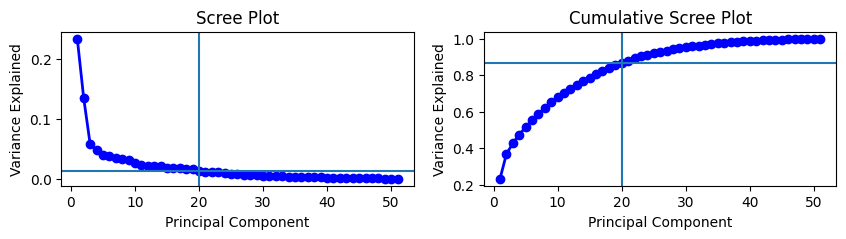

In [9]:
PC_values = np.arange(pca.n_components_) + 1
cutoff=20

plt.figure(figsize = (10,2))
plt.subplot(1,2,1)
plt.plot(PC_values, pca.explained_variance_ratio_, 'o-', linewidth=2, color='blue')
plt.title('Scree Plot')
plt.axvline(x=cutoff)
plt.axhline(y=pca.explained_variance_ratio_[cutoff-1])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')

plt.subplot(1,2,2)
plt.plot(PC_values, np.cumsum(pca.explained_variance_ratio_), 'o-', linewidth=2, color='blue')
plt.title('Cumulative Scree Plot')
plt.axvline(x=cutoff)
plt.axhline(y=np.cumsum(pca.explained_variance_ratio_)[cutoff-1])
plt.xlabel('Principal Component')
plt.ylabel('Variance Explained')
plt.show()

Visualize the class distribution of the adsorption sites

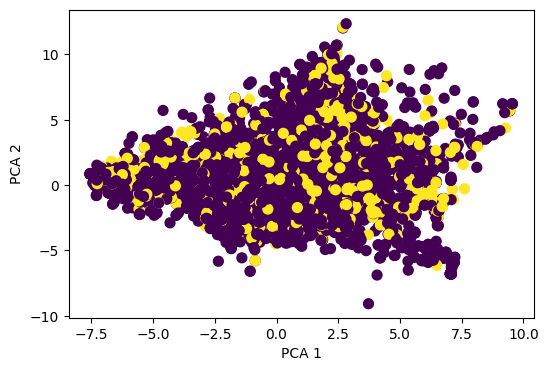

In [10]:
# Visualize the classification of the adsorption sites based on the first two PCs
plt.figure(figsize=(6,4))
plt.scatter(pos[:,0],pos[:,1],s=50,c = df['label'])
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()

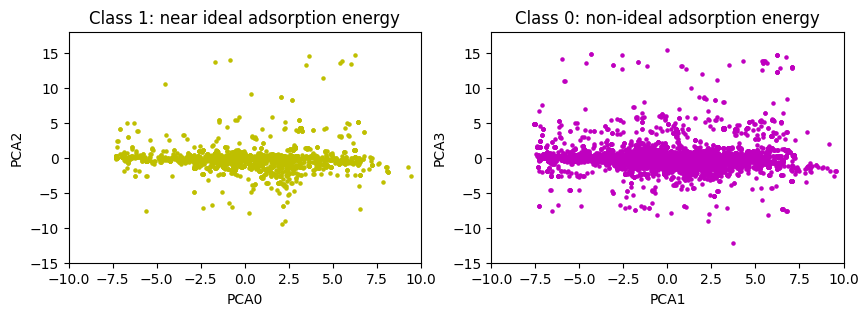

In [11]:
# Plot the classification of the adsorption sites in seperate panels 
# the 3rd PC is found to have more correlation with the adsorption energy -> ideal adsorption sites is more likely to have a zero 3rd PC
L1 = np.where(df['label']==1)[0]
L0 = np.where(df['label']==0)[0]
PC = [0,2]

plt.figure(figsize=(10,3))

plt.subplot(1,2,1)
plt.scatter(pos[L1,PC[0]],pos[L1,PC[1]],s=5,c = 'y')
plt.xlabel('PCA'+str(PC[0]))
plt.xlim((-10,10))
plt.ylim((-15,18))
plt.ylabel('PCA'+str(PC[1]))
plt.title('Class 1: near ideal adsorption energy')

plt.subplot(1,2,2)
plt.scatter(pos[L0,PC[0]],pos[L0,PC[1]],s=5, c ='m')
plt.xlabel('PCA'+str(PC[0]+1))
plt.xlim((-10,10))
plt.ylim((-15,18))
plt.ylabel('PCA'+str(PC[1]+1))
plt.title('Class 0: non-ideal adsorption energy')

plt.show()

### 2.2 LOCO-CV Folds Definition

the LOCO is defined according to K-means clustering

In [12]:
inertias = {}
for k in range(1,20):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(pos[:,:20])
    inertias[k] = kmeans.inertia_ 

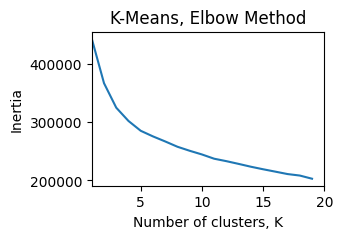

In [13]:
plt.figure(figsize=(3,2));
plt.plot(list(inertias.keys()), list(inertias.values()));
plt.title('K-Means, Elbow Method')
plt.xlabel("Number of clusters, K");
plt.xlim((1,20))
plt.ylabel("Inertia");

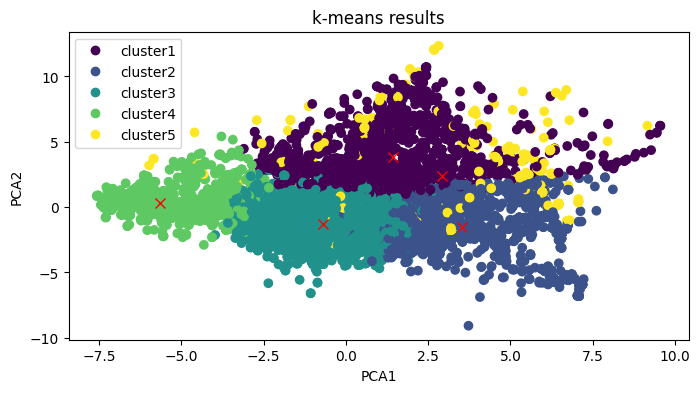

In [24]:
k = 5
plt.figure(figsize = (8,4))
kmeans = KMeans(n_clusters=k, random_state =42).fit(pos[:,:20]) # perform clustering over the PCs
L = kmeans.labels_
label = []
for i in range(k):                                        # generate label for each cluster
    label.append('cluster'+str(i+1))         
cluster_centers = kmeans.cluster_centers_
plt.subplot(1,1,1)
scatter = plt.scatter(pos[:,0],pos[:,1],c = L)
plt.plot(cluster_centers[:,0], cluster_centers[:,1], 'rx', markersize=7)
plt.xlabel('PCA1')
plt.ylabel('PCA2')
plt.legend(scatter.legend_elements()[0],label)
plt.title('k-means results')
plt.show()

In [15]:
from sklearn.model_selection import LeaveOneGroupOut
X = df.iloc[:,5:].to_numpy()
y = df['label'].to_numpy()

logo = LeaveOneGroupOut().split(X, y, groups=L)
i=0
logo_list=[]
for train_index, test_index in logo:
    print("cluster_leaved:", L[test_index][0]+1,"  TRAIN:", len(train_index), "TEST:", len(test_index))
    logo_list.append([train_index,test_index])
    i+=1

cluster_leaved: 1   TRAIN: 8160 TEST: 1840
cluster_leaved: 2   TRAIN: 7635 TEST: 2365
cluster_leaved: 3   TRAIN: 6239 TEST: 3761
cluster_leaved: 4   TRAIN: 8340 TEST: 1660
cluster_leaved: 5   TRAIN: 9626 TEST: 374


### 2.3 Model fitting 

#### 2.3.1 Model 1: KNN 


##### LOCO CV

hyperparameter tuning based on LOCO

In [39]:
KN = range(30,40)
LOCO_average = []
for i in KN:
    clf = KNeighborsClassifier(n_neighbors=i)
    switch = 3
    scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
    scaler = scaler_list[switch]

    LOCO_score = []

    print()
    for group in logo_list:
        train_index, test_index = group
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        clf.fit(X_train,y_train)
        # Make predictions
        y_train_pred = clf.predict(X_train) 
        AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        LOCO_score.append(AUC)
    LOCO_average.append(np.mean(LOCO_score))

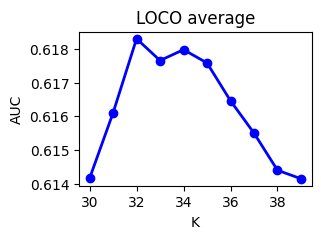

In [17]:
# plot the LOCO_average vs KN
plt.figure(figsize=(3,2))
plt.plot(KN, LOCO_average, 'o-', linewidth=2, color='blue')
plt.title('LOCO average')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

<Figure size 200x200 with 0 Axes>

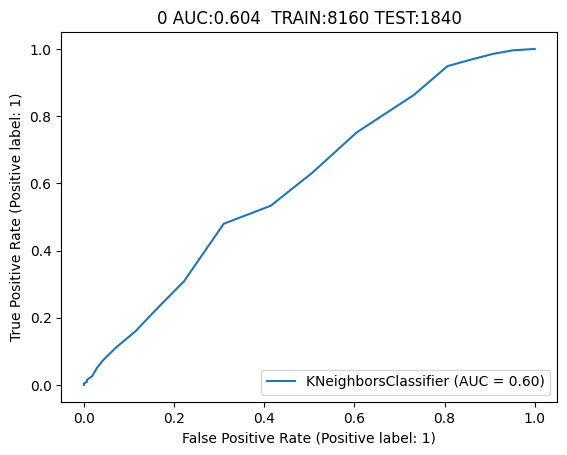

<Figure size 200x200 with 0 Axes>

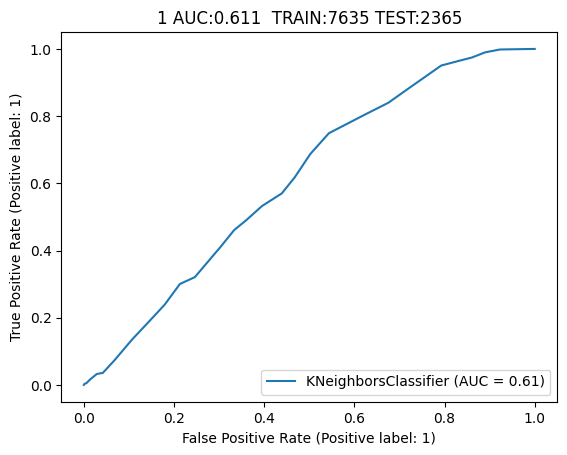

<Figure size 200x200 with 0 Axes>

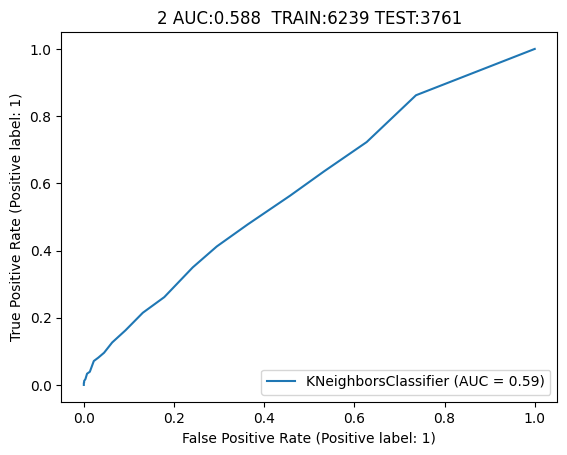

<Figure size 200x200 with 0 Axes>

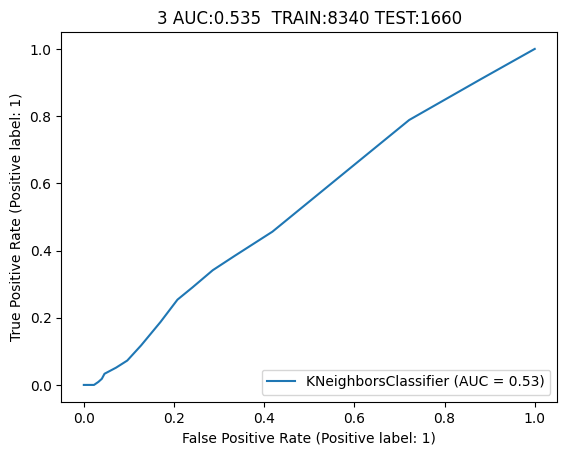

<Figure size 200x200 with 0 Axes>

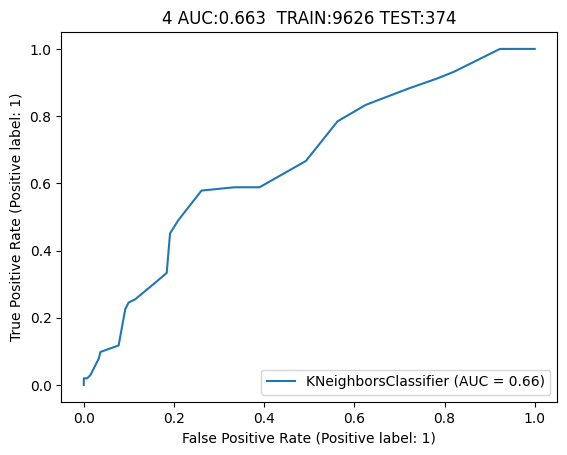

In [193]:
clf = KNeighborsClassifier(n_neighbors=32)
switch = 3
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[switch]

LOCO_score = []
LOCO_KNN_misclassified = []

i=0
for group in logo_list:
    train_index, test_index = group
    
    X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    clf.fit(X_train,y_train)
    # Make predictions
    # y_train_pred = clf.predict(X_train) 
    y_test_pred = clf.predict(X_test) 
    # Store the misclassified samples   
    misclassified = np.where(y_test != y_test_pred)[0]
    LOCO_KNN_misclassified.append(test_index[misclassified])

    AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    #print(AUC)
    LOCO_score.append(AUC)
    title = str(L[test_index][0])+' AUC:'+str(round(AUC,3))+"  TRAIN:"+str(len(train_index))+" TEST:"+str(len(test_index))
    # plot the ROC curve
    plt.figure(figsize=(2,2))
    plot_roc_curve(clf, X_test, y_test)
    plt.title(title)

    i+=1
    
LOCO_KNN_misclassified = np.concatenate(LOCO_KNN_misclassified)

##### Random CV

hyperparameter tuning based on random CV

In [89]:
KN = range(1,15,2)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)

RandomCV_average = []
for i in KN:
    clf = KNeighborsClassifier(n_neighbors=i)
    switch = 1
    scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
    scaler = scaler_list[switch]

    RandomCV_score=[]

    for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        clf.fit(X_train,y_train)
        # Make predictions
        y_train_pred = clf.predict(X_train) 
        AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        #print(AUC)
        RandomCV_score.append(AUC)
    RandomCV_average.append(np.mean(RandomCV_score))

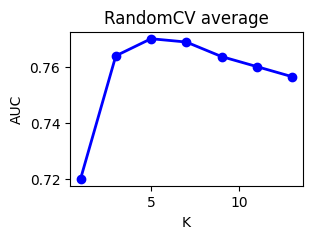

In [90]:
# plot the LOCO_average vs KN
plt.figure(figsize=(3,2))
plt.plot(KN, RandomCV_average, 'o-', linewidth=2, color='blue')
plt.title('RandomCV average')
plt.xlabel('K')
plt.ylabel('AUC')
plt.show()

RF recall score: 0.422
RF recall score: 0.403
RF recall score: 0.416
RF recall score: 0.405
RF recall score: 0.396


<Figure size 200x200 with 0 Axes>

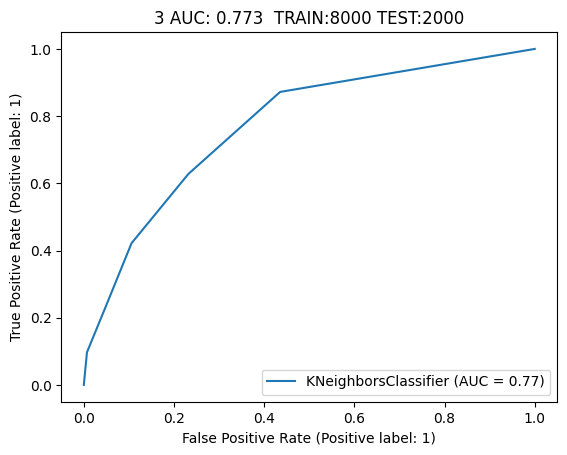

<Figure size 200x200 with 0 Axes>

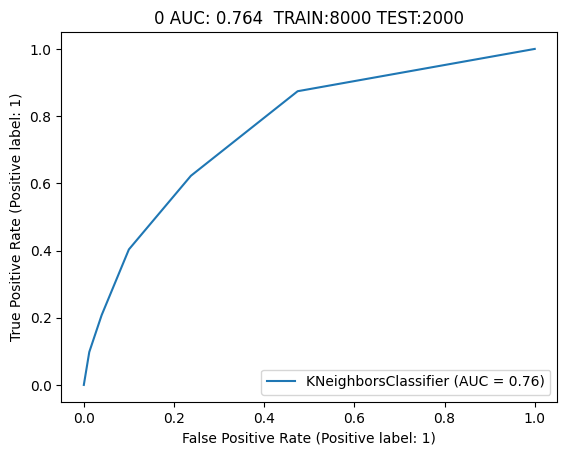

<Figure size 200x200 with 0 Axes>

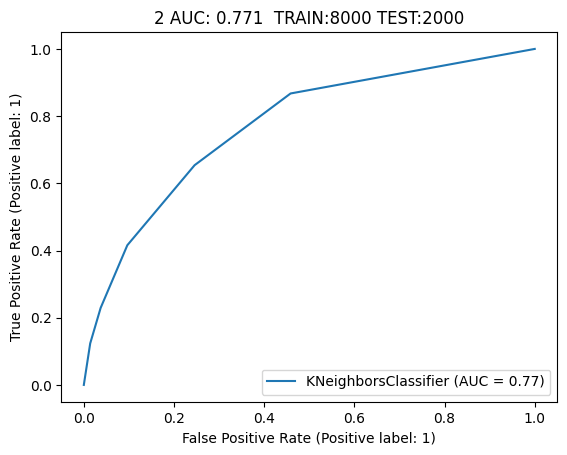

<Figure size 200x200 with 0 Axes>

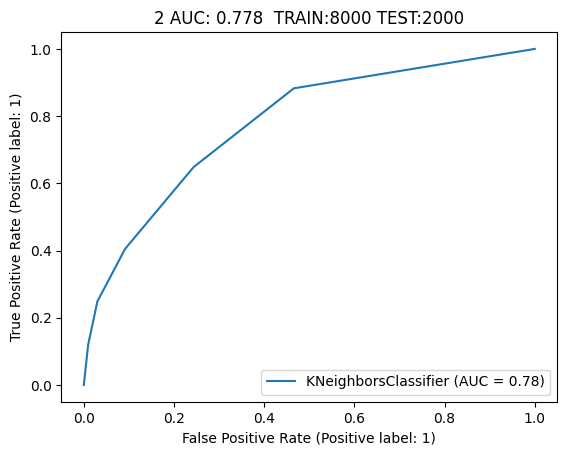

<Figure size 200x200 with 0 Axes>

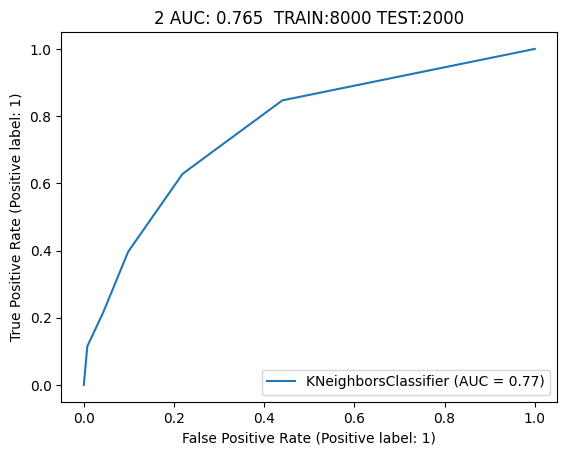

In [218]:
clf = KNeighborsClassifier(n_neighbors=5)
switch = 1
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[switch]

RandomCV_score=[]
RandomCV_KNN_misclassified = []

# define a random cross-validation splitter
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in cv.split(X):
    X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    clf.fit(X_train,y_train)
    # Make predictions
    # y_train_pred = clf.predict(X_train) 
    y_test_pred = clf.predict(X_test)
    misclassified = np.where(y_test != y_test_pred)[0]
    RandomCV_KNN_misclassified.append(test_index[misclassified])

    AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    #print(AUC)
    RandomCV_score.append(AUC)
    title = str(L[test_index][0])+' AUC: '+str(round(AUC,3))+"  TRAIN:"+str(len(train_index))+" TEST:"+str(len(test_index))
    print("RF recall score:",round(sklearn.metrics.recall_score(y_test, y_test_pred),3))
    # plot the ROC curve
    plt.figure(figsize=(2,2))
    plot_roc_curve(clf, X_test, y_test)
    plt.title(title)

RandomCV_KNN_misclassified = np.concatenate(RandomCV_KNN_misclassified)

##### CV summary
The accuracy for random CV and LOCO CV are plotted together for comparison. 

A general trend displayed is that the random CV have overall much better AUC score than the LOCO-CV.
It is because, the LOCO-CV folds is splitted according to the result of K-mean clustering. Since the data with more similar features(e.g. similar materials) tends to be clustered together and each cluster could have very different character from each other, that is, when we leave one cluster out, the feature of that one might not be able to be learnt from the other training input clusters, and leading to a low valid_AUC. Therefore which cluster is leave out could have great impact on the valid_AUC. 

This specific trend can be represented by the valid_AUC of leave-cluster-4/5-out. cluster 4 is relatively away from the whold distribution as displayed in k-means result plot (especially w.r.t PC1), and therefore it is more difficult for the model to capture their character from training clusters, resulting a very low validation accuracy. While the datapoints of cluster 5 are spreading through the whole dataset, therefore the feature-target relation is well captured and resulting the highest valid_AUC among the LOCO-CV folds. 

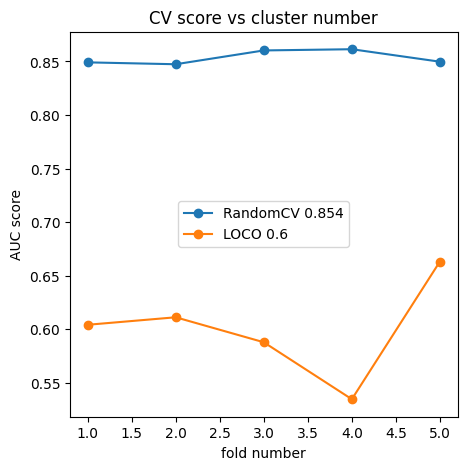

In [194]:
# plot the RandomCV score vs cluster number
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,6),RandomCV_score,'o-',label='RandomCV '+str(round(np.mean(RandomCV_score),3)))
plt.plot(np.arange(1,6),LOCO_score,'o-',label='LOCO '+str(round(np.mean(LOCO_score),3)))
plt.legend(loc='center')
plt.xlabel('fold number')
plt.ylabel('AUC score')
plt.title('CV score vs cluster number')
plt.show()


##### Train a full data model
The full data model have a higher accuracy than the both the LOCO-CV & random-CV model, which is expected since standardization is performed over the whole dataset and the "testing" is performed on the data that have already been seen. 

Text(0.5, 1.0, 'Full data model AUC: 0.861')

<Figure size 200x200 with 0 Axes>

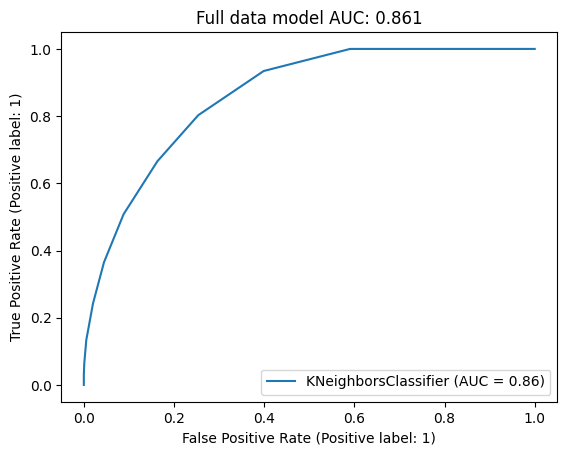

In [102]:
clf = KNeighborsClassifier(n_neighbors=10)  # the number of neighbors is increased in comparison to the random CV to prevent overfitting
 
X = scaler.fit_transform(X)
y = y
# Train the model
clf.fit(X,y)
# Make predictions
y_pred = clf.predict(X) 
# Store the misclassified samples
full_KNN_missclassified = np.where(y != y_pred)[0]

AUC = roc_auc_score(y, clf.predict_proba(X)[:, 1])
plt.figure(figsize=(2,2))
plot_roc_curve(clf, X, y)
title = 'Full data model AUC: '+str(round(AUC,3))
plt.title(title)

In [71]:
len(full_KNN_missclassified)
len(RandomCV_KNN_misclassified)
len(LOCOO_KNN_misclassified)

2452

#### 2.3.2 Model 2: RandomForest

##### LOCO CV

In [76]:
# hyperparameter tuning based on LOCO CV
depth = range(1,10)
LOCO_average = []
for i in depth:
    clf = RandomForestClassifier(max_depth=i, random_state=0)
    switch = 0
    scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
    scaler = scaler_list[switch]

    LOCO_score = []

    print()
    for group in logo_list:
        train_index, test_index = group
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        clf.fit(X_train,y_train)
        # Make predictions
        y_train_pred = clf.predict(X_train) 
        AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        LOCO_score.append(AUC)
    LOCO_average.append(np.mean(LOCO_score))

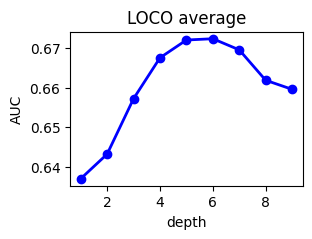

In [77]:
# plot the LOCO_average vs depth
plt.figure(figsize=(3,2))
plt.plot(depth, LOCO_average, 'o-', linewidth=2, color='blue')
plt.title('LOCO average')
plt.xlabel('depth')
plt.ylabel('AUC')
plt.show()

RF recall score: 0.0
RF recall score: 0.0
RF recall score: 0.0
RF recall score: 0.003
RF recall score: 0.0


<Figure size 200x200 with 0 Axes>

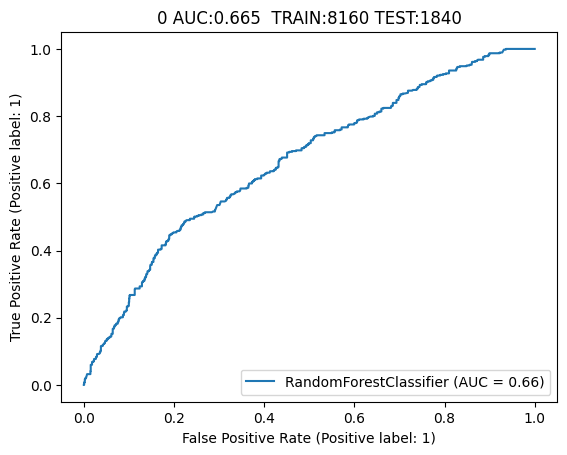

<Figure size 200x200 with 0 Axes>

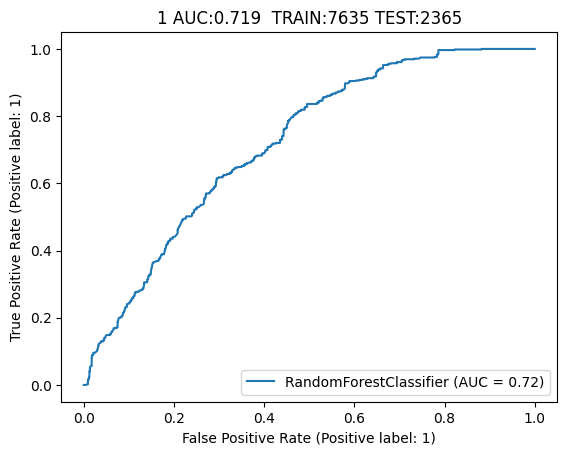

<Figure size 200x200 with 0 Axes>

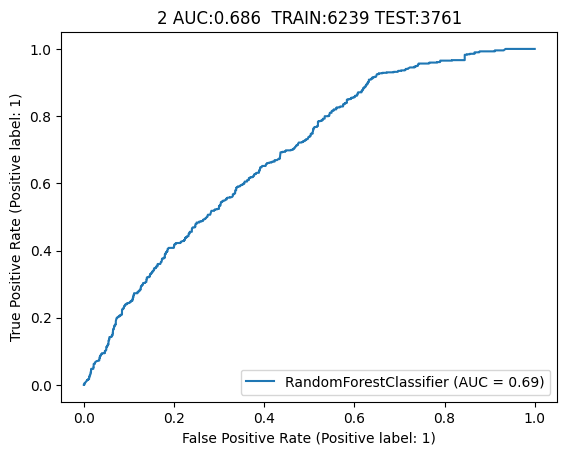

<Figure size 200x200 with 0 Axes>

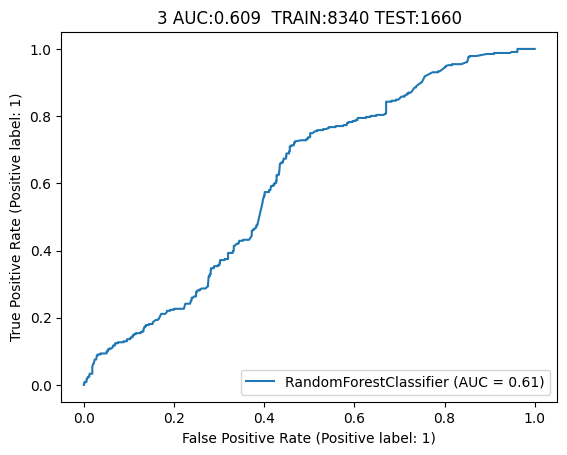

<Figure size 200x200 with 0 Axes>

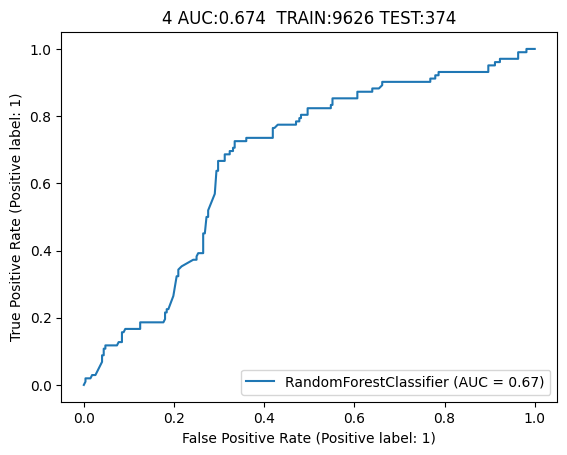

In [217]:
# select the best depth and perform the LOCO CV
clf = RandomForestClassifier(max_depth=6, random_state=42)
switch = 1
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[switch]

LOCO_score = []
LOCO_RF_misclassified = []

i=0
for group in logo_list:
    train_index, test_index = group
    
    X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    clf.fit(X_train,y_train)
    # Make predictions
    # y_train_pred = clf.predict(X_train) 
    y_test_pred = clf.predict(X_test) 
    # Store the misclassified samples   
    misclassified = np.where(y_test != y_test_pred)[0]
    LOCO_RF_misclassified.append(test_index[misclassified])

    AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    #print(AUC)
    LOCO_score.append(AUC)
    title = str(L[test_index][0])+' AUC:'+str(round(AUC,3))+"  TRAIN:"+str(len(train_index))+" TEST:"+str(len(test_index))

    print("RF recall score:",round(sklearn.metrics.recall_score(y_test, y_test_pred),3))
    # plot the ROC curve
    plt.figure(figsize=(2,2))
    plot_roc_curve(clf, X_test, y_test)
    plt.title(title)

    #plot_confusion_matrix(clf, X_test, y_test)

    i+=1
    
LOCO_RF_misclassified = np.concatenate(LOCO_RF_misclassified)

##### Random CV

In [93]:
# tune the hyperparameter based on the random CV
depth = range(15,30,2)
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
RandomCV_average = []

for i in depth:
    clf = RandomForestClassifier(max_depth=i)
    switch = 1
    scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
    scaler = scaler_list[switch]

    RandomCV_score=[]

    for train_index, test_index in cv.split(X):
        X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
        y_train, y_test = y[train_index], y[test_index]
        # Train the model
        clf.fit(X_train,y_train)
        # Make predictions
        y_train_pred = clf.predict(X_train) 
        AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
        #print(AUC)
        RandomCV_score.append(AUC)
    RandomCV_average.append(np.mean(RandomCV_score))

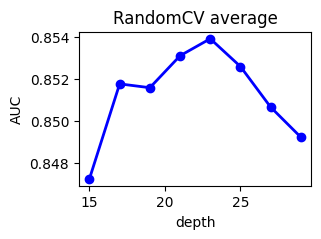

In [94]:
# plot the RandomCV_average vs depth
plt.figure(figsize=(3,2))
plt.plot(depth, RandomCV_average, 'o-', linewidth=2, color='blue')
plt.title('RandomCV average')
plt.xlabel('depth')
plt.ylabel('AUC')
plt.show()

RF recall score: 0.498
RF recall score: 0.501
RF recall score: 0.51
RF recall score: 0.538
RF recall score: 0.489


<Figure size 200x200 with 0 Axes>

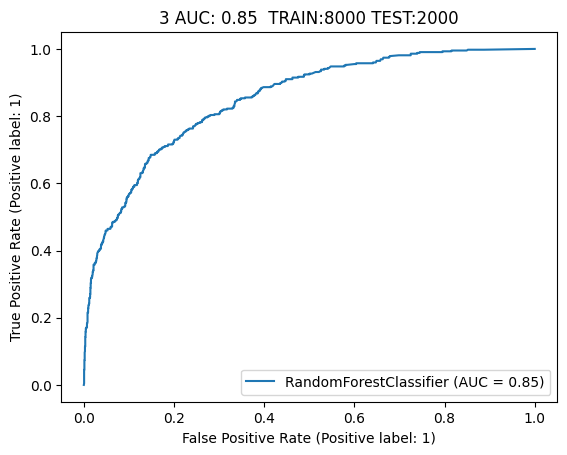

<Figure size 200x200 with 0 Axes>

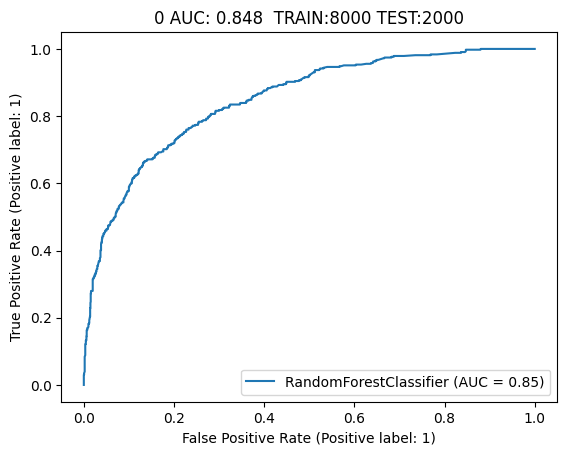

<Figure size 200x200 with 0 Axes>

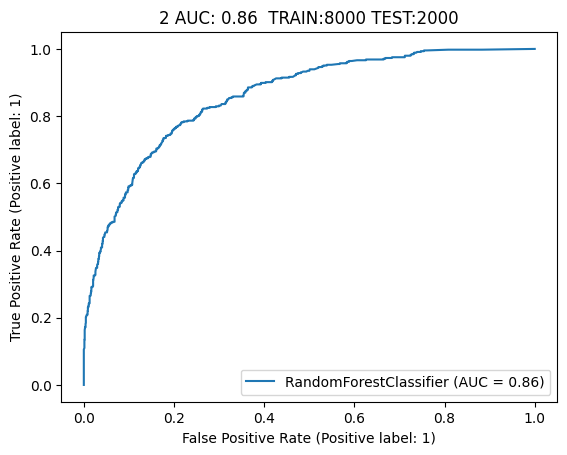

<Figure size 200x200 with 0 Axes>

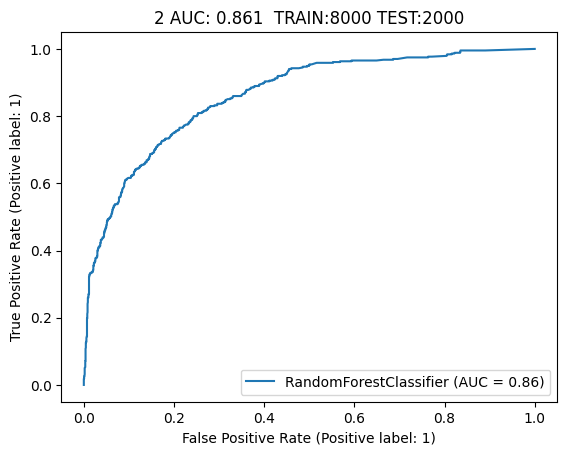

<Figure size 200x200 with 0 Axes>

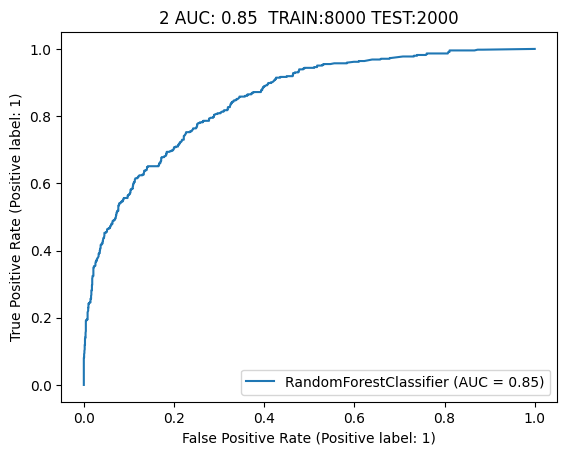

In [216]:
# select the best depth and perform the random CV
clf = RandomForestClassifier(max_depth=23, random_state=0)
switch = 1
scaler_list = [StandardScaler(), QuantileTransformer(), Normalizer(), RobustScaler()]
scaler = scaler_list[switch]

RandomCV_score=[]
RandomCV_RF_misclassified = []

# define a random cross-validation splitter
cv = ShuffleSplit(n_splits=5, test_size=0.2, random_state=0)
for train_index, test_index in cv.split(X):
    X_train, X_test = scaler.fit_transform(X[train_index]), scaler.transform(X[test_index])
    y_train, y_test = y[train_index], y[test_index]
    
    # Train the model
    clf.fit(X_train,y_train)
    # Make predictions
    # y_train_pred = clf.predict(X_train) 
    y_test_pred = clf.predict(X_test)
    misclassified = np.where(y_test != y_test_pred)[0]
    RandomCV_RF_misclassified.append(test_index[misclassified])

    AUC = roc_auc_score(y_test, clf.predict_proba(X_test)[:, 1])
    #print(AUC)
    RandomCV_score.append(AUC)
    title = str(L[test_index][0])+' AUC: '+str(round(AUC,3))+"  TRAIN:"+str(len(train_index))+" TEST:"+str(len(test_index))

    print("RF recall score:",round(sklearn.metrics.recall_score(y_test, y_test_pred),3))
    # plot the ROC curve
    plt.figure(figsize=(2,2))
    plot_roc_curve(clf, X_test, y_test)
    plt.title(title)

RandomCV_RF_misclassified = np.concatenate(RandomCV_RF_misclassified)

##### CV summary
The general trend is similar to the KNN model, that random CV have overall much higher validation AUC for the same reason explained above. The speicific trend for LOCO-CV is also similar to the KNN model, that is, the cluster 4 also has the lowest valid_AUC as expected. However the cluster 5 no longer has the highest valid_AUC, instead, cluster 2 does and is further confirmed by alternating the random seeds. It simply seems that the feature of cluster 2 can be well captured by the random forest model, which is not just about the distance as KNN model, but have a more complex relation with the target (feature divisions). 


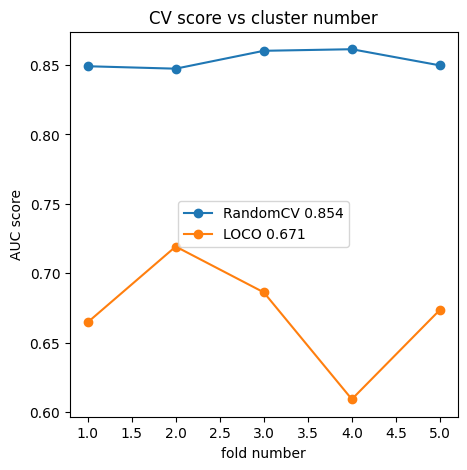

In [110]:
# plot the RandomCV score vs cluster number
plt.figure(figsize=(5,5))
plt.plot(np.arange(1,6),RandomCV_score,'o-',label='RandomCV '+str(round(np.mean(RandomCV_score),3)))
plt.plot(np.arange(1,6),LOCO_score,'o-',label='LOCO '+str(round(np.mean(LOCO_score),3)))
plt.legend(loc='center')
plt.xlabel('fold number')
plt.ylabel('AUC score')
plt.title('CV score vs cluster number')
plt.show()

##### Train a full data model

The full data model have a higher accuracy than the LOCO-CV / random-CV model, which is expected since standardization and training is performed over the whole dataset. Randomforest, as a tree-based model, is not sensitive to the distribution of the data, but just have very high expressive power in terms of modeling various functions. It might results in overfitting, which could be another cause for a high "training accuracy".

Text(0.5, 1.0, 'Full data model AUC: 0.95')

<Figure size 200x200 with 0 Axes>

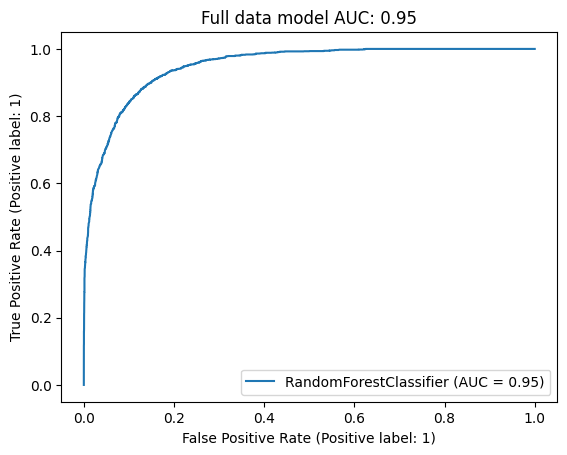

In [233]:
clf = RandomForestClassifier(max_depth=12, random_state=0)  # the max_depth is decreased in comparison to the random CV to prevent overfitting 
 
X = scaler.fit_transform(X)
y = y
# Train the model
clf.fit(X,y)
# Make predictions
y_pred = clf.predict(X) 
# Store the misclassified samples
full_RF_missclassified = np.where(y != y_pred)[0]

AUC = roc_auc_score(y, clf.predict_proba(X)[:, 1])
plt.figure(figsize=(2,2))
plot_roc_curve(clf, X, y)
title = 'Full data model AUC: '+str(round(AUC,3))
plt.title(title)

### 2.4 Visualization of Classification Results of Full data model

The classification results are visualized by confusion matrix and Classification probability distribution w.r.t. PC1 & PC2.

Results Summary:
* The KNN and RF model have fairly close accuracy (0.827 vs 0.874). 
* The RF model have a very good precision score(0.93) other than the KNN model. 
* Both model have a much lower recall score than their precision, due to the imbalanced class distribution, which could be improve by altering the classfication threshold or widening the margin of "near-ideal adsorption site" (label = 1). 


Precision: model say it is, it actually is  
Recall: knowing how many, what proportion can be detected/sensitivity



In [234]:
X = scaler.fit_transform(X)
y = y

KNN = KNeighborsClassifier(n_neighbors=10)
RF = RandomForestClassifier(max_depth=12, random_state=0) 

# Train the model
KNN.fit(X,y)
RF.fit(X,y)

# Make predictions
y_pred_KNN = KNN.predict(X)
y_pred_RF = RF.predict(X)


#### 2.4.1 Confusion Matrix

KNN accuracy:  0.827
KNN precision:  0.694
KNN recall score: 0.365 

RF accuracy:  0.874
RF precision:  0.93
RF recall score: 0.454


<Figure size 500x500 with 0 Axes>

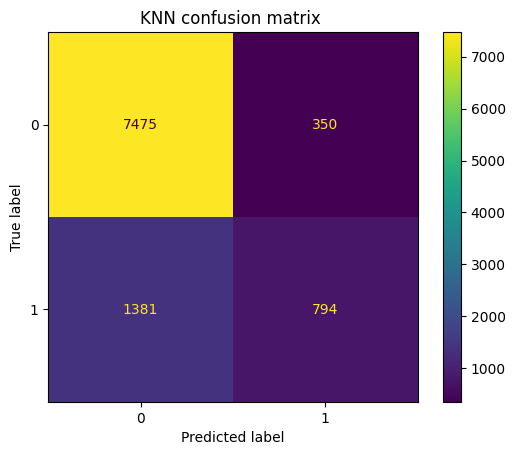

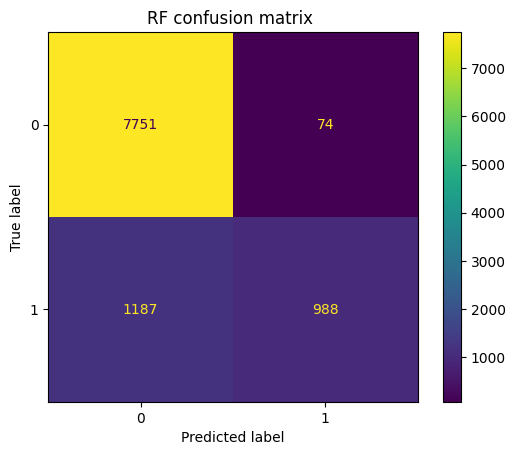

In [235]:
plt.figure(figsize=(5,5))
# plot the confusion matrix of KNN
#plt.subplot(1,2,1)
plot_confusion_matrix(KNN, X, y)
title = 'KNN confusion matrix '
plt.title(title)
print("KNN accuracy: ", round(sklearn.metrics.accuracy_score(y, y_pred_KNN),3))
print("KNN precision: ", round(sklearn.metrics.precision_score(y, y_pred_KNN),3))
print("KNN recall score:",round(sklearn.metrics.recall_score(y, y_pred_KNN),3),'\n')

# plot the confusion matrix of RF
#plt.subplot(1,2,2)
plot_confusion_matrix(RF, X, y)
title = 'RF confusion matrix '
print("RF accuracy: ", round(sklearn.metrics.accuracy_score(y, y_pred_RF),3))
print("RF precision: ", round(sklearn.metrics.precision_score(y, y_pred_RF),3))
print("RF recall score:",round(sklearn.metrics.recall_score(y, y_pred_RF),3))
plt.title(title)
plt.show()

### 2.4.2 Classification Probability Distribution Plot

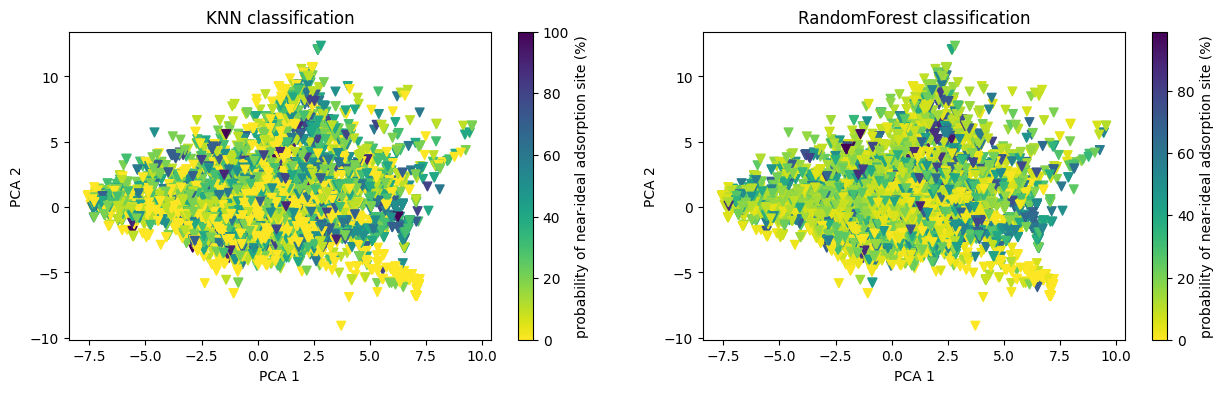

In [236]:
# Visualize the classification probability of the adsorption sites based on the first two PCs
plt.figure(figsize=(15,4))

plt.subplot(1,2,1)
proba = KNN.predict_proba(X)[:,1]*100
cmap = plt.cm.viridis_r
norm = plt.Normalize(0, proba.max())
plt.scatter(pos[:,0],pos[:,1], s=40, c = cmap(norm(proba)), marker='v')
# show colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='probability of near-ideal adsorption site (%)')
plt.title('KNN classification')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.subplot(1,2,2)
proba = RF.predict_proba(X)[:,1]*100
cmap = plt.cm.viridis_r
norm = plt.Normalize(0, proba.max())
plt.scatter(pos[:,0],pos[:,1], s=40, c = cmap(norm(proba)), marker='v')
# show colorbar
sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])
plt.colorbar(sm, label='probability of near-ideal adsorption site (%)')
plt.title('RandomForest classification')
plt.xlabel('PCA 1')
plt.ylabel('PCA 2')

plt.show()

### 2.5 Comparison of the misclassified regions 

The misclassified regions are visualized through plotting the missclassified data points on the PC1-PC2 plot. The color represents the true label of the datapoints.
Both KNN and RF displayed the same trend that 
1. for accuracy, full data > Random CV > LOCO CV  
2. for recall, Random CV > full data > LOCO CV 
  
It indicated that the feature-target relation is fairly unique for each cluster (i.e. adsortions sites of different element species tends to have a different feature-to-near-ideal-adsorption-site relation), and is very difficult to be captured by training the model using a completely different material system. The success of random CV indicated that feature-target relation is identically distributed over the training sets and the test folds.  

To be noticed that for both KNN and RF, the complexity of the full data model are intensionally lowered in comparison to random CV models to prevent overfitting. If the same hyperparameters are used for the full data models, they would likely have a higher recall score than the random CV model. 

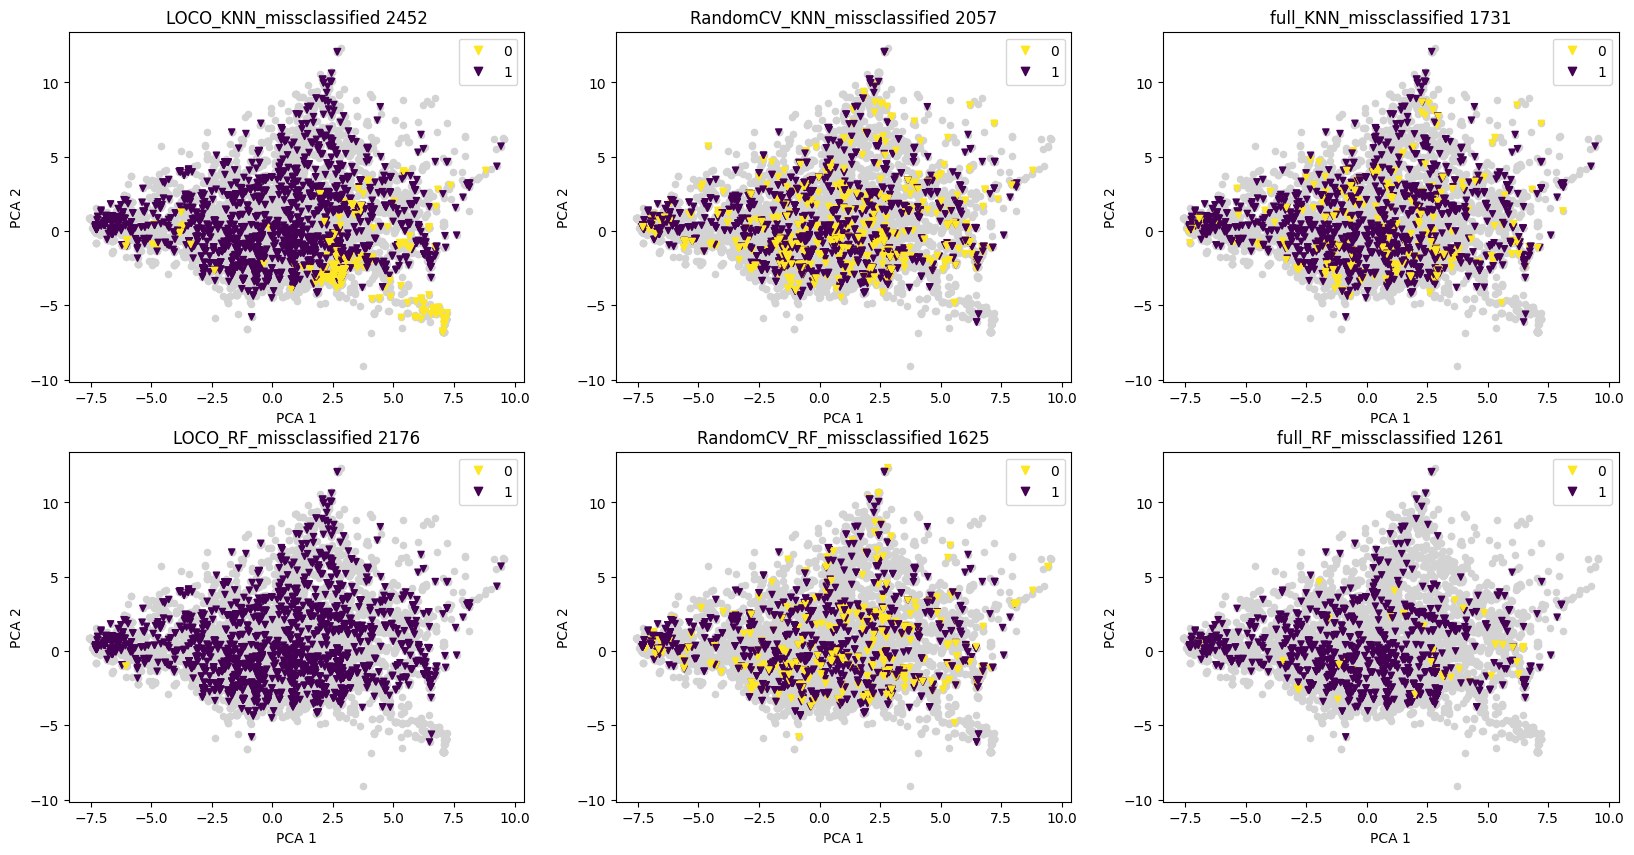

In [238]:
# Visualize the classification probability of the adsorption sites based on the first two PCs
model_name = ['KNN', 'RF']
model = ['LOCO', 'RandomCV', 'full']
index = [LOCO_KNN_misclassified, RandomCV_KNN_misclassified, full_KNN_missclassified, LOCO_RF_misclassified, RandomCV_RF_misclassified, full_RF_missclassified]

plt.figure(figsize=(20,10))

n = 0
for i in range(2):
    for j in range(3):
        title = model[j]+'_'+model_name[i]+'_missclassified '+str(len(index[n]))
        # print(index[n])
        true_label=y[index[n]]
        plt.subplot(2,3,n+1)
        plt.scatter(pos[:,0],pos[:,1], s=20, c='lightgrey')
        scatter = plt.scatter(pos[index[n],0],pos[index[n],1], s=20, c=true_label, cmap='viridis_r',marker='v')
        plt.legend(scatter.legend_elements()[0],['0','1'])

        plt.title(title)
        plt.xlabel('PCA 1')
        plt.ylabel('PCA 2')  

        n+=1

# Summary

In general, there was no clear distribution segregation among the non/near-ideal adsorption sites according to the PCA plot. That said, it seems ideal adsorption sites are more likely to have a zero PC3
According to previous clustering analysis, each cluster corresponds to the clustering of a different material system/element species. The well mixed class distribution, indicated that the adsorption energy is not just about the material system but also strongly depends on the local environment of the sites.(various systems can have their own ideal adsorption sites configurations)

The detailed description of the misclassified regions are shown in section 2.5 already.

Propose 10 new materials:  
Since my dataset are featurized from detailed structure information, and is extremely time and effort consuming to be generated by myself. The 10 new materials are pulled from the hidden dataset that was not used for training/validation. The prediction results is that all the target are non-ideal sites. The results are farly trustworthy, since the ideal-adsorption site is very rare after all. That said, if the RF model predicted one to be ideal-adsorption site, it is very likely to be a good candidate for further study.

In [261]:
df_test = pd.read_csv('h_data_hidden.csv').drop(columns=['Unnamed: 0'])
samples = df.sample(11, random_state=1)
samples

,label,mpid,formula,chemsys,energy,shift,miller,top,0group,0period,...,9en,9upd,10group,10period,10en,10upd,11group,11period,11en,11upd
9953,0,mp-22646,InPd2,"[In, Pd]",0.087845,0.079682,9,1,10,5,...,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000,13.000000,5.000000,1.780000,0.000000
3850,0,mp-570744,Si3As4,"[As, Si]",0.499692,0.180325,8,0,15,4,...,1.900000,0.000000,14.000000,3.000000,1.900000,0.000000,14.000000,3.000000,1.900000,0.000000
4962,0,mp-11397,Ga3Ni2,"[Ga, Ni]",0.040062,0.035393,4,1,13,4,...,1.810000,0.000000,13.000000,4.000000,1.810000,0.000000,10.000000,4.000000,1.910000,2.000000
3886,0,mp-16356,TiNiGe,"[Ge, Ni, Ti]",-0.551282,0.082375,10,0,10,4,...,2.010000,0.000000,14.000000,4.000000,2.010000,0.000000,14.000000,4.000000,2.010000,0.000000
5437,0,mp-1018121,TiPd2,"[Pd, Ti]",-0.397912,0.078228,15,1,10,5,...,2.200000,0.000000,10.000000,5.000000,2.200000,0.000000,4.000000,4.000000,1.540000,2.000000
8517,0,mp-4076,VCoSb,"[Co, Sb, V]",-0.512486,0.000000,9,0,9,4,...,2.050000,0.000000,15.000000,5.000000,2.050000,0.000000,5.000000,4.000000,1.630000,3.000000
2041,0,mp-1057,Al3Ni2,"[Al, Ni]",-0.488359,0.375125,2,1,10,4,...,1.610000,0.000000,13.000000,3.000000,1.610000,0.000000,13.000000,3.000000,1.610000,0.000000
1989,0,mp-19962,Sn2Pt,"[Pt, Sn]",0.095260,0.041667,9,0,10,6,...,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966,10.068966,4.689655,1.980345,1.068966
1933,1,mp-867792,ReIr3,"[Ir, Re]",-0.291865,0.000000,7,0,9,6,...,2.200000,3.000000,9.000000,6.000000,2.200000,3.000000,9.000000,6.000000,2.200000,3.000000
9984,0,mp-1645,Al9Rh2,"[Al, Rh]",0.050183,0.125000,11,0,13,3,...,1.610000,0.000000,9.000000,5.000000,2.280000,2.000000,10.068966,4.689655,1.980345,1.068966


In [262]:
L_KNN = KNN.predict(samples.iloc[:,5:])
L_RF = RF.predict(samples.iloc[:,5:])
print(L_KNN)
print(L_RF)

[0 0 0 0 0 0 0 0 0 0 0]
[0 0 0 0 0 0 0 0 0 0 0]


From the prediction result probability of the full model, taking the datapoints of with probability closer to 0 or 1 (where model tends to be more confident about the prediction result), and maybe away from the region of only 0 class, can potentially improve the overall predictive performance.